In [10]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import random

#Import Libraries

#   Printing the some calibration images


Creating a list using glob and printing 3 random images 

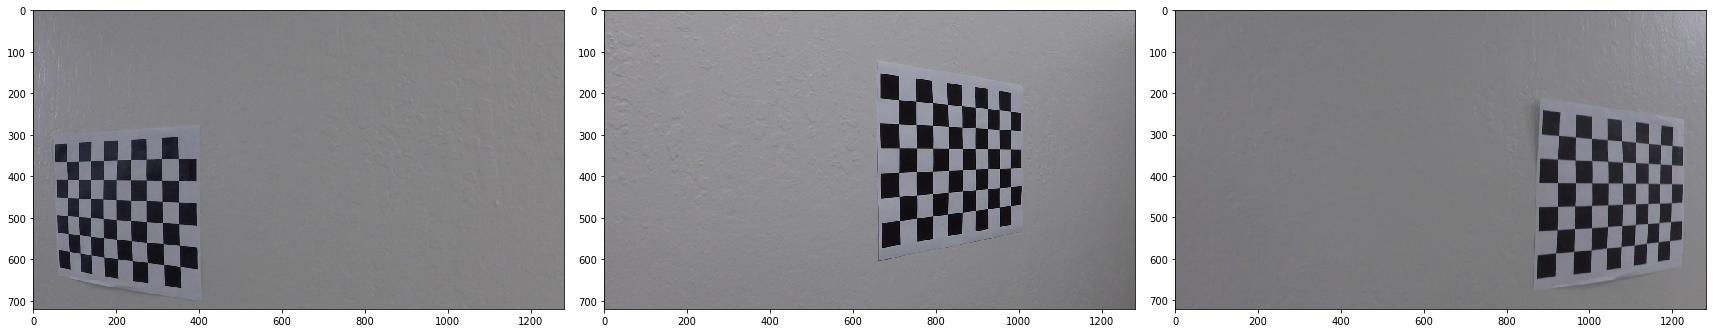

In [31]:
calib_list = glob.glob("D:\\Udacity_SDCND\\CarND-Advanced-Lane-Lines\\camera_cal\*.jpg")
list = random.sample(range(1,20),3)
fig,axes = plt.subplots(1,3,figsize=(24,9))
cntr =0
for img in list:
    fig.tight_layout()
    image = mpimg.imread(calib_list[img])
    axes[cntr].imshow(image)
    cntr+=1
plt.show()

# Calibrating the Images

Got all the image paths using glob , iterating through all images 
Using the code from tutorial , get cameramatrix using OpenCv Calibrate Camera 

In [63]:
nx = 9
ny = 6

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for image in calib_list:
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret==True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
#Compute CameraMatrix , Distortion Coefficeints using object points and image points obtained from above
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# Distortion Correction

Using Camera Matrix , Distortion Coefficients obtained above apply undistortion to all the images
Showing Sample of Undistorted Image

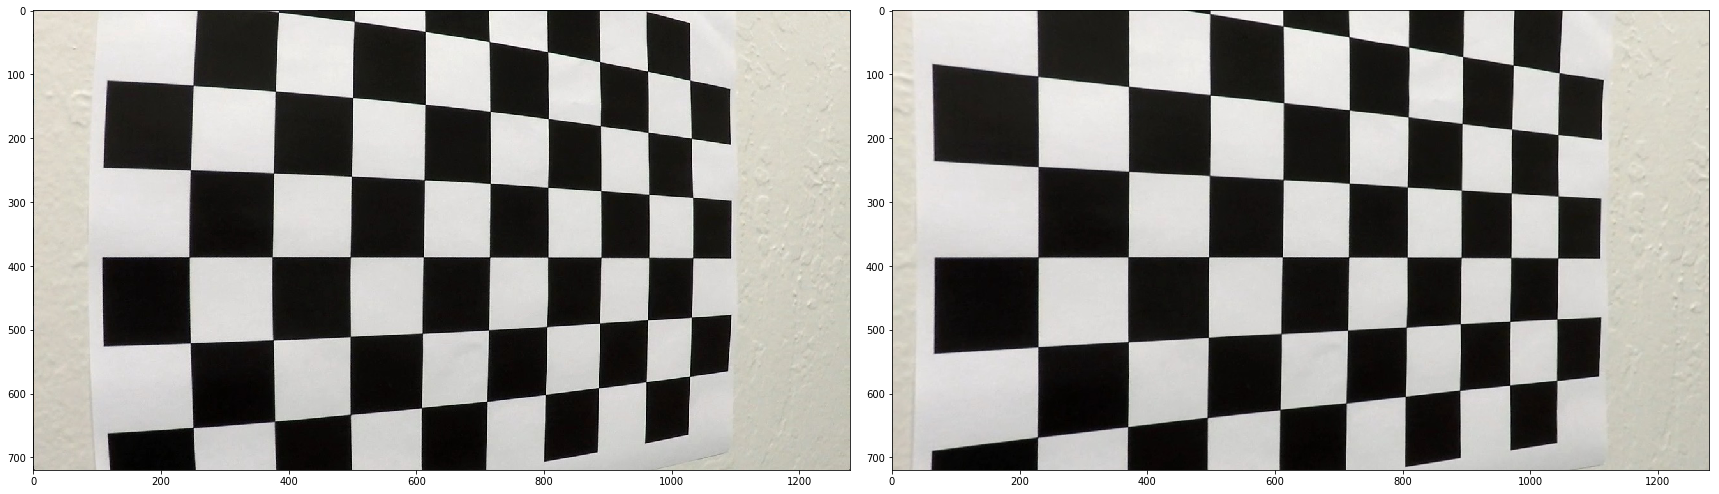

In [54]:
image = mpimg.imread("D:\\Udacity_SDCND\\CarND-Advanced-Lane-Lines\\camera_cal\\calibration5.jpg")
fig,(axis1,axis2) = plt.subplots(1,2,figsize=(24,9))
fig.tight_layout()
axis1.imshow(image)
dist = cv2.undistort(image,mtx,dist,None,mtx)
axis2.imshow(dist)
plt.show()

# Gradients and Threshold

In [55]:
def color_gradient(img):
    
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #Get the shape of the image
    ht, wd = gray.shape
    
    # Apply sobel in the x direction
    sobelx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    
    # Apply the directional threshold for edge detection
    direction_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # Combining Sobelx and Direction binary 
    combined_binary = ((sobelx_binary == 1) & (direction_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])

    # Combining all the thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined_binary)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,ht-1], [wd/2, int(0.5*ht)], [wd-1, ht-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    final_output = cv2.bitwise_and(color_combined, mask)
    return final_output

#Apply Sobel
def abs_sobel_thresh(gray, orientation='x', thresh_min=0, thresh_max=255):
    if orientation == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

#Applying Magnitude Threshold
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    abs_sobelx = np.absolute(sobelx)
    abs_sobel =  np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

#Apply Directional Threshold
def dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3)):
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobely = np.absolute(sobely)
    abs_sobelx = np.absolute(sobelx)
    grad = np.arctan2(abs_sobely,abs_sobelx)
    binary_output =  np.zeros_like(grad)
    binary_output[(grad >= thresh[0]) & (grad <= thresh[1])] = 1
    return binary_output


Example of Combined Binary Thresholded Image

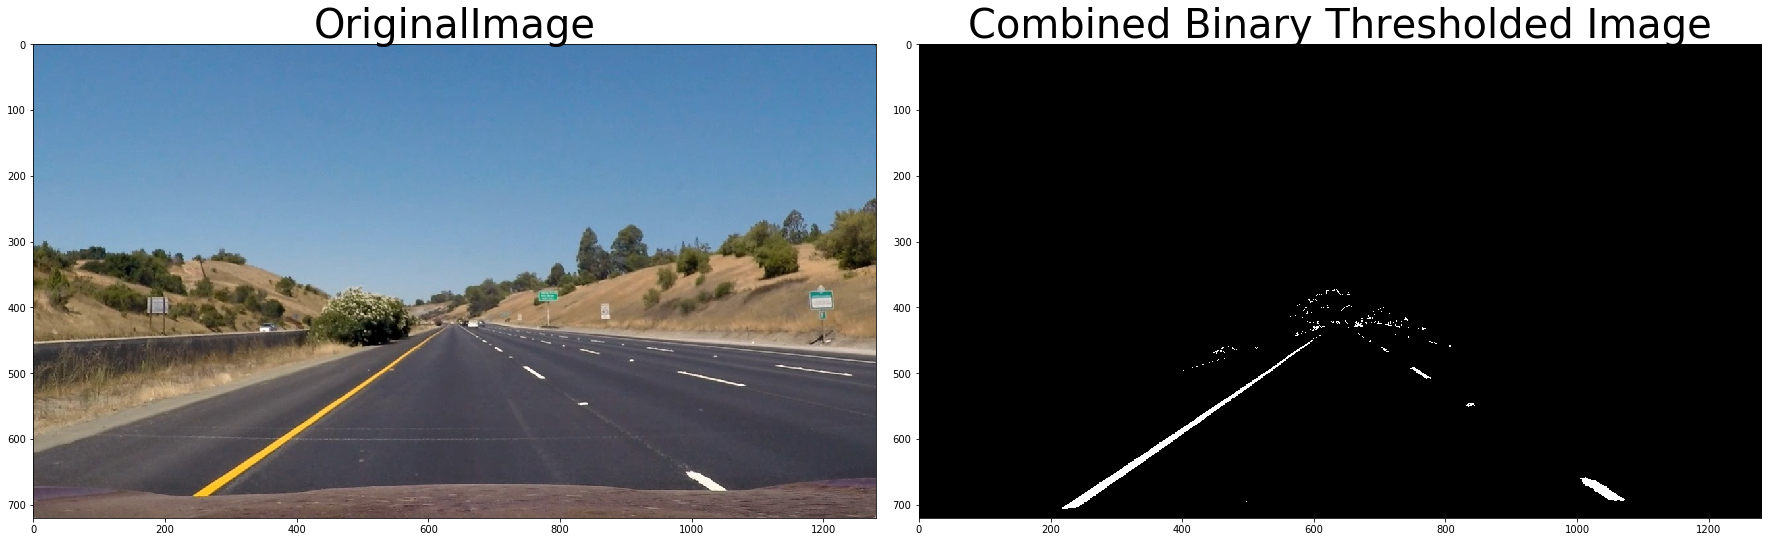

In [145]:
img = mpimg.imread("D:\\Udacity_SDCND\\CarND-Advanced-Lane-Lines\\test_images\\straight_lines1.jpg")
combined_binary = color_gradient(img)
cv2.imwrite('combined_binary_threshold.jpg',combined_binary)

# Plot the 2 images side by side
f, (axis1, axis2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
axis1.imshow(img)
axis1.set_title('OriginalImage', fontsize=40)
axis2.imshow(combined_binary, cmap='gray')
axis2.set_title('Combined Binary Thresholded Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Perspective Transform : Bird's Eye View

Get the Bird's Eye view of Combined Binary Thresholded Image by changing the perspective
By doing this we get the parallel lines
Using the tutorial code

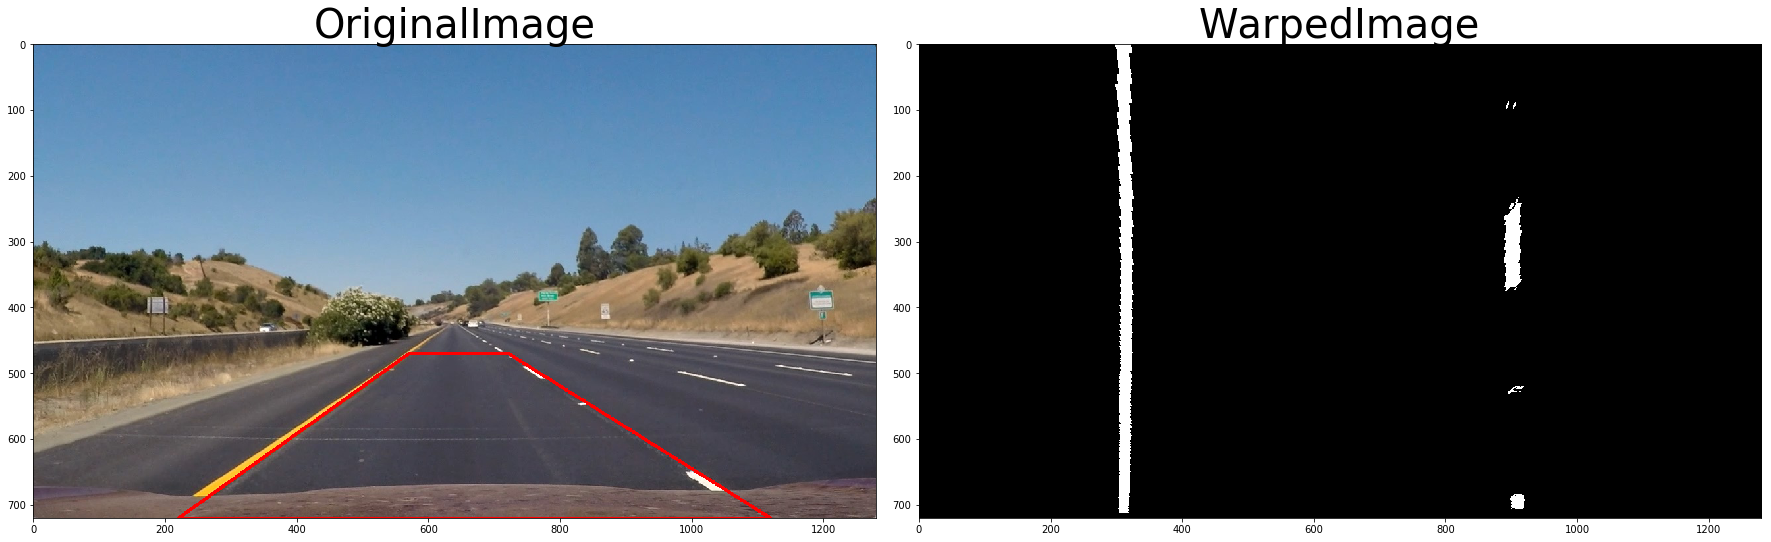

In [115]:
# Source Points calculated manually 
leftbottm = [220,720]
rightbottom = [1120, 720]
leftop = [570, 470]
righttop = [722, 470]

src = np.float32([leftbottm,rightbottom,righttop,leftop])

srcpts = np.array([leftbottm,rightbottom,righttop,leftop], np.int32)
srcpts = srcpts.reshape((-1,1,2))
copy = img.copy()
cv2.polylines(copy,[srcpts],True,(255,0,0), thickness=3)

# Destination points
leftbottm = [320,720]
rightbottom = [920, 720]
leftop = [320, 5]
righttop = [920, 1]

dst = np.float32([leftbottm,rightbottom,righttop,leftop])
img_p = cv2.getPerspectiveTransform(src, dst)
img_p_inv = cv2.getPerspectiveTransform(dst, src)

warped_image = cv2.warpPerspective(combined_binary, img_p, gray.shape[::-1] , flags=cv2.INTER_LINEAR)
    
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
axis1.imshow(copy)
axis1.set_title('OriginalImage', fontsize=40)
axis2.imshow(warped_image, cmap='gray')
axis2.set_title('WarpedImage', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Lane Finding : Using Histogram Technique

Plot histogram for the warped image ,each peak in the histogram indicates lane line

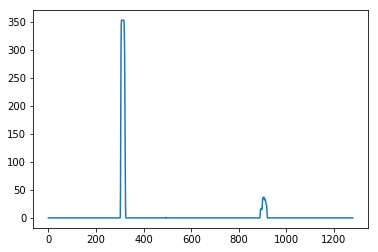

In [116]:
histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

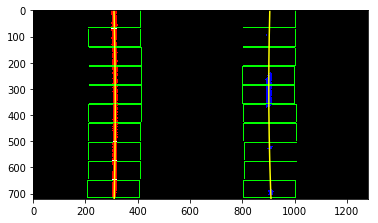

In [117]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped_image, warped_image, warped_image))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 10
# Set height of windows
window_height = np.int(warped_image.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped_image.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 100
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped_image.shape[0] - (window+1)*window_height 
    win_y_high = warped_image.shape[0] - window*window_height -5
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

Visualize the Result

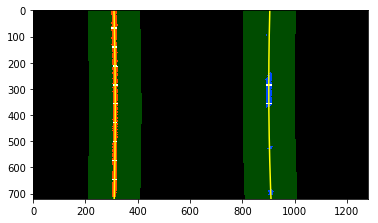

In [118]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped_image, warped_image, warped_image))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

Measuring the Curvature

In [136]:
def cal_curvature_radius(values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

left_curve_rad = cal_curvature_radius(leftx)
right_curve_rad = cal_curvature_radius(rightx)
average_curve_rad = (left_curve_rad + right_curve_rad)/2
curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
print(curvature_string)

# compute the offset from the center
lane_center = (rightx[719] + leftx[719])/2
xm_per_pix = 3.7/700 # meters per pixel in x dimension
center_offset_pixels = abs(gray.shape[0]/2 - lane_center)
center_offset_mtrs = xm_per_pix*center_offset_pixels
offset_string = "Center offset: %.2f m" % center_offset_mtrs
print(offset_string)


Radius of curvature: 530.61 m
Center offset: 0.90 m


Apply back the results to Original image

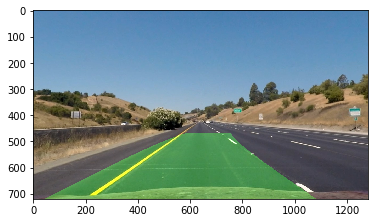

In [121]:
warp_zero = np.zeros_like(warped_image).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
img = mpimg.imread("D:\\Udacity_SDCND\\CarND-Advanced-Lane-Lines\\test_images\\straight_lines1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, img_p_inv, (gray.shape[1], gray.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.show()

# Final Pipeline

In [141]:
# Some global variables
left_lines=None
right_lines=None

past_leftlines = []
past_rightlines = []

meandifference_btwn_lines = 0

def get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows):
    #This function generates the prediction of the lane lines
    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]
    
    # If no pixels were found return None
    if(left_y.size == 0 or left_x.size == 0):
        return None, None

    # Fit the polynomial
    left_lines = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]
    
    # If no pixels were found return None
    if(right_y.size == 0 or right_x.size == 0):
        return None, None

    # Fit the polynomial
    right_lines = np.polyfit(right_y, right_x, 2)

    # If no pixels were found return None
    ploty = np.linspace(0, num_rows-1, num_rows)
    
    # Generate the lane lines from the polynomial fit
    left_x_predictions = left_lines[0]*ploty**2 + left_lines[1]*ploty + left_lines[2]
    right_x_predictions = right_lines[0]*ploty**2 + right_lines[1]*ploty + right_lines[2]
    
    return left_x_predictions, right_x_predictions

def findlanes_usinghistogram(warped):
    """
       This function searches for the lane lines using the histogram method used in the tutorial
    """
    #histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

    half_width = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:half_width])
    rightx_base = np.argmax(histogram[half_width:]) + half_width

    num_windows = 10
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50

    min_pixels = 100

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        left_x_min = leftx_base - window_half_width
        left_x_max = leftx_base + window_half_width

        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))

        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width

        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)
    
    left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    return left_x_predictions, right_x_predictions

def get_averaged_line(previous_lines, new_line):
    
    #This function is used to calculate lines by averaging over previous frames
    # Number of frames to calculate average over
    num_frames = 12
    
    if new_line is None:    
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            #Append lines until we reach the required num_frames
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # Calculate the average over last num_frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line
        
        
def mean_distance_btwn_lines(left_line, right_line, running_average):
    #Calculate running average of difference between the lines
    mean_distance = np.mean(right_line - left_line)
    if running_average == 0:
        running_average = mean_distance
    else:
        running_average = 0.9*running_average + 0.1*mean_distance
    return running_average
    

def pipeline_final(img):
    #Variables to store polynomial coefficients for the detected lines
    global left_lines
    global right_lines
    
    # Variables to store line coordinates in the previous frames
    global past_rightlines
    global past_leftlines
    
    #Variable containing the running average of difference between the lines
    global meandifference_btwn_lines
    
    img_shape = img.shape
    img_size = (img_shape[1], img_shape[0])
    
    # Get Thresholded Gradient Image
    thresholded = color_gradient(img)
    
    # Perform perspective transform
    warped = cv2.warpPerspective(thresholded, img_p, img_size , flags=cv2.INTER_LINEAR)
    
    out_img = np.dstack((warped, warped, warped))*255
    
    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (left_lines is None) or (right_lines is None):
        #Check if the lanes from the previous frame are not found then find the lanes using histogram technique
        blnfindlanes = True
        left_x_predictions, right_x_predictions = findlanes_usinghistogram(warped)
    else:
        blnfindlanes = False
        margin = 100
        left_x_predictions = left_lines[0]*non_zeros_y**2 + left_lines[1]*non_zeros_y + left_lines[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = right_lines[0]*non_zeros_y**2 + right_lines[1]*non_zeros_y + right_lines[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_predictions, right_x_predictions = get_line_predictions(non_zeros_x, non_zeros_y, left_coordinates, right_coordinates, num_rows)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not blnfindlanes:
            left_x_predictions, right_x_predictions = findlanes_usinghistogram(warped)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if meandifference_btwn_lines == 0:
            meandifference_btwn_lines = mean_difference
        
        if (mean_difference < 0.7*meandifference_btwn_lines or mean_difference > 1.3*meandifference_btwn_lines):
            bad_lines = True
            if not blnfindlanes:
                left_x_predictions, right_x_predictions = findlanes_usinghistogram(warped)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*meandifference_btwn_lines or mean_difference > 1.3*meandifference_btwn_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        left_lines = None
        right_lines = None
        if len(left_lines) == 0 and len(right_lines) == 0:
            return img
        else:
            left_x_predictions = left_lines[-1]
            right_x_predictions = right_lines[-1]
    else:
        past_leftlines, left_x_predictions = get_averaged_line(past_leftlines, left_x_predictions)
        past_rightlines, right_x_predictions = get_averaged_line(past_rightlines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        meandifference_btwn_lines = 0.9*meandifference_btwn_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    # Calculate the radius of curvature
    left_curve_rad = cal_curvature_radius(left_x_predictions)
    right_curve_rad = cal_curvature_radius(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # Calculate the offset from the center
    lane_center = (right_x_predictions[num_rows-1] + left_x_predictions[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped = cv2.warpPerspective(out_img, img_p_inv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

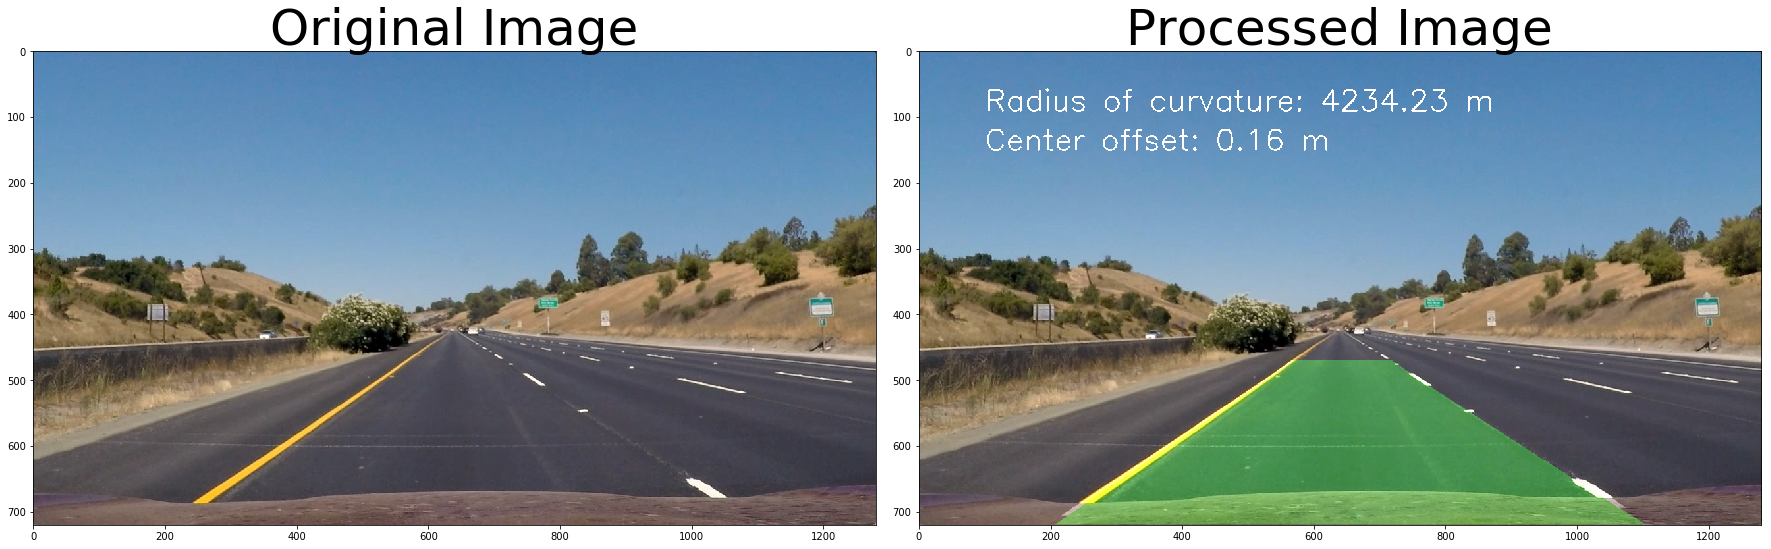

In [155]:
img = mpimg.imread("D:\\Udacity_SDCND\\CarND-Advanced-Lane-Lines\\test_images\\straight_lines1.jpg")

#Initialize Global Variables again
left_lines = None
right_lines = None
past_rightlines = []
past_leftlines = []
meandifference_btwn_lines = 0

name = 'D:\\Udacity_SDCND\\CarND-Advanced-Lane-Lines\\output_images\\output_straight_lines1.jpg'
# Apply pipeline
processed_image = pipeline_final(img)
cv2.imwrite(name,processed_image)
# Plot the 2 images
f, (axis1, axis2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
axis1.imshow(img)
axis1.set_title('Original Image', fontsize=50)
axis2.imshow(processed_image, cmap='gray')
axis2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

Test the pipeline on Project Video

In [139]:
from moviepy.editor import VideoFileClip

In [140]:
left_lines = None
right_lines = None
past_rightlines = []
past_leftlines = []
meandifference_btwn_lines = 0

output_video = 'project_video_output.mp4'
clip1 = VideoFileClip("D:\\Udacity_SDCND\\CarND-Advanced-Lane-Lines\\project_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:23<00:00,  3.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 7min 25s
